In [1]:
! pip install ./python_files
from python_files import *
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available, training on: ", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


Processing c:\users\tbird\documents\github\06-665-psm-final-project\python_files
  Created wheel for python-files: filename=python_files-0.1.0-py3-none-any.whl size=1023 sha256=302f04fff40b7e94f4a98e60930ea0772197aaab374910884293b65f3f10a521
  Stored in directory: C:\Users\tbird\AppData\Local\Temp\pip-ephem-wheel-cache-cjgx_gtx\wheels\ca\c1\3d\7f33f532b3f9eddd59bbd2ddd1f7583d50a6829274a8d07efa
Successfully built python-files
  Attempting uninstall: python-files
    Found existing installation: python-files 0.1.0
    Uninstalling python-files-0.1.0:
      Successfully uninstalled python-files-0.1.0
GPU is available, training on:  NVIDIA GeForce RTX 2070 Super with Max-Q Design


# NN Training and Testing

### Getting data for the NN training and testing

In [4]:
# loading data from saved folder
solutions = np.load("./saved/100_solutions.npy")
F_ag_array = np.load("./saved/100_F_ag.npy")
test_solutions = np.load("./saved/10test_solutions.npy")
test_F_ag_array = np.load("./saved/10test_F_ag.npy")
num_timesteps = 500
# Concatenating training data before preprocessing
solutions_w_F_ag = np.concatenate((solutions, F_ag_array.reshape(100,1,num_timesteps)), axis=1)
# Preprocessing training data
train_data = data_preprocessing(solutions_w_F_ag, N = 100, num_timesteps = num_timesteps, batch_size = 1, shuffle = False)
print("Training data preprocessing done")
# Concatenating test data before preprocessing
test_solutions_w_F_ag = np.concatenate((test_solutions, test_F_ag_array.reshape(10,1,num_timesteps)), axis=1)
# Preprocessing test data
test_data = data_preprocessing(test_solutions_w_F_ag, N = 10, num_timesteps = num_timesteps, batch_size = 1, shuffle = False)
print("Test data preprocessing done")

pre-processing data with N = 100
Training data preprocessing done
pre-processing data with N = 10
Test data preprocessing done


### The following block only needs to be used if new data is needed

In [ ]:

# N = 100
# solutions_name = str(N) + "_solutions.npy"
# F_ag_array_name = str(N) + "_F_ag.npy"
# save_dir = "./saved"
# os.makedirs (save_dir, exist_ok=True)

# num_timesteps = 500
# train_random_inputs = generate_inputs (N)
# solutions, F_ag_array = generate_ode_data(train_random_inputs, num_timesteps)

# print ("="*50)
# print ("Saved: ")
# print (f"{solutions_name}: {solutions.shape}")
# print (f"{F_ag_array_name}: {F_ag_array.shape}")
# print ("="*50)

# # SAVE
# np.save (join(save_dir, solutions_name), solutions)
# np.save (join(save_dir, F_ag_array_name), F_ag_array)

# # PLOT
# plot_ode_solutions (solutions)
# plot_input_output(F_ag_array, solutions, N)


### Training the NN

In [5]:
# Initialize the NN
model = NeuralNet(num_hidden_layers = 2, input_size = 8, hidden_size = 64, output_size = 1)#, device = device)
# Train the NN
train_and_test(model, train_data, test_data, optimizer = "Adam", num_epochs = 20)

# Testing the NN

### The following block only needs to be used if new data is needed

In [ ]:
# N = 10
# test_solutions_name = str(N) + "test_solutions.npy"
# test_F_ag_array_name = str(N) + "test_F_ag.npy"
# save_dir = "./saved"
# os.makedirs (save_dir, exist_ok=True)


# test_random_inputs = generate_inputs (N)
# test_solutions, test_F_ag_array = generate_ode_data(test_random_inputs, num_timesteps=500)

# print ("="*50)
# print ("Saved: ")
# print (f"{test_solutions_name}: {test_solutions.shape}")
# print (f"{test_F_ag_array_name}: {test_F_ag_array.shape}")
# print ("="*50)

# # SAVE
# np.save (join(save_dir, test_solutions_name), test_solutions)
# np.save (join(save_dir, test_F_ag_array_name), test_F_ag_array)

# # PLOT
# plot_ode_solutions (test_solutions)
# plot_input_output(test_F_ag_array, test_solutions, N)

### Testing the NN

pre-processing data... with N =  10
Total test loss for set n =  0 : 47.72876397371292


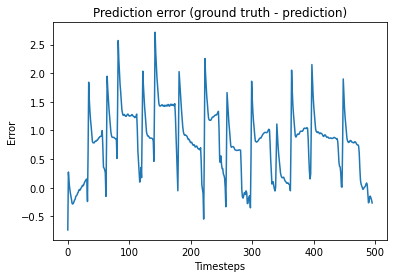

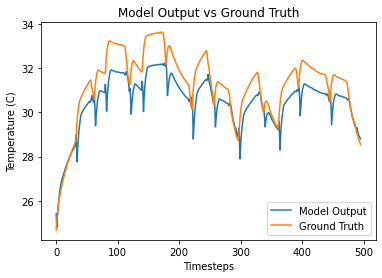

Total test loss for set n =  1 : 40.95666992640123


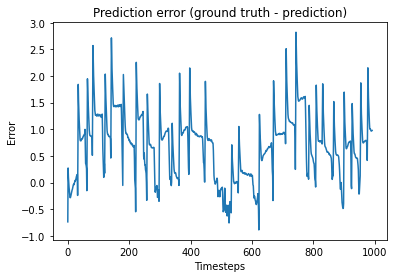

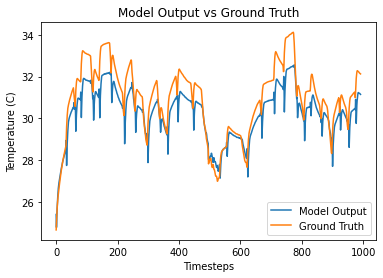

Total test loss for set n =  2 : 54.37343230030872


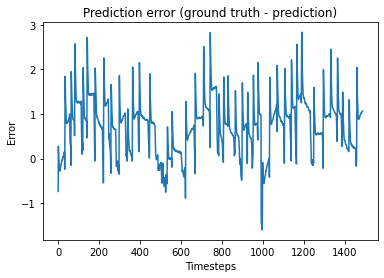

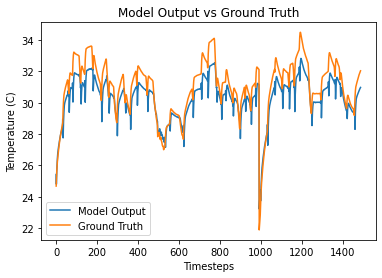

Total test loss for set n =  3 : 48.22488817975614


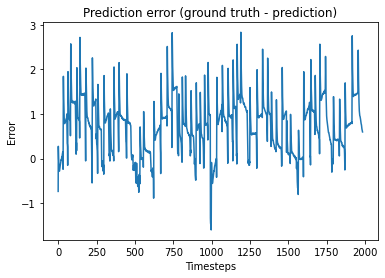

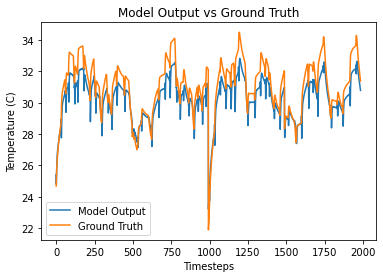

Total test loss for set n =  4 : 38.71759267210284


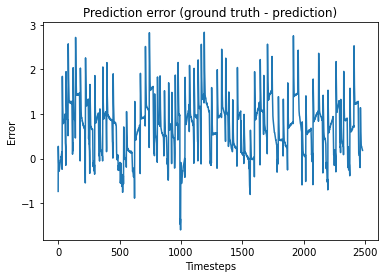

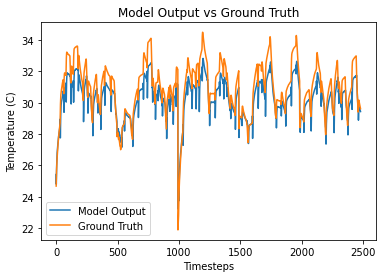

Total test loss for set n =  5 : 30.470474793448368


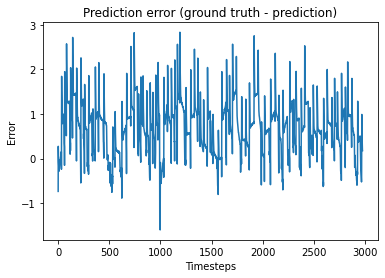

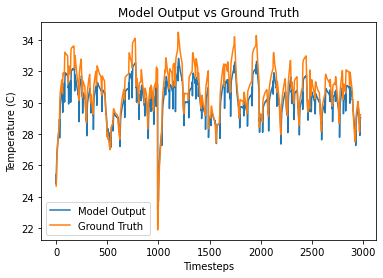

Total test loss for set n =  6 : 34.25731021639549


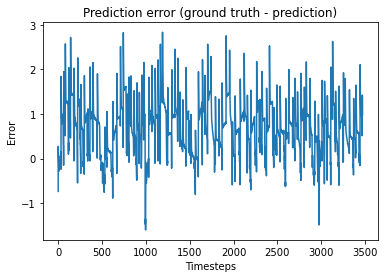

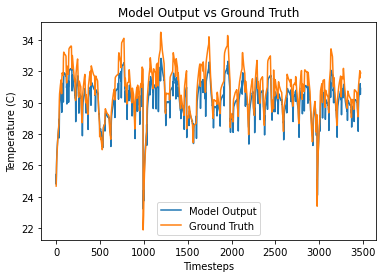

Total test loss for set n =  7 : 46.03128871061712


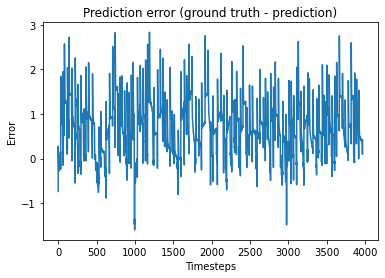

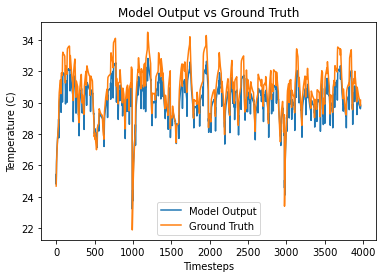

Total test loss for set n =  8 : 56.69714588645926


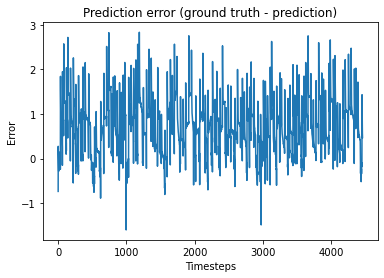

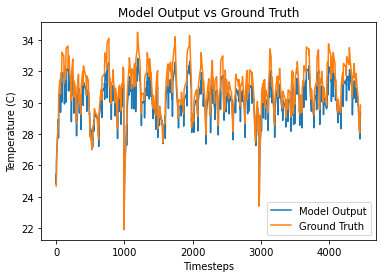

Total test loss for set n =  9 : 59.67949997444831


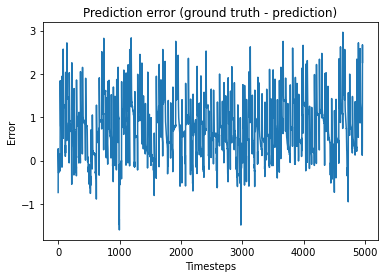

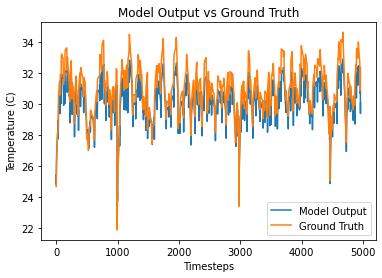

In [ ]:
test(model, test_data)